## Import

In [1]:
from datetime import datetime
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt

#
import seaborn as sns
#

from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from pycaret.classification import *
from pycaret.utils import version
SEED =37

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed_everything(SEED) # Seed 고정
def norm(df):
    df_normalized = (df - df.mean()) / df.std()
    df_normalized.head()
    df_normalized.dropna(axis=1)
    return df_normalized

## Data Load

In [3]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

In [4]:
train_x = train_df.drop(columns=['PRODUCT_ID', 'Y_Class', 'Y_Quality'])
train_y = train_df['Y_Class']

test_x = test_df.drop(columns=['PRODUCT_ID'])

## Data Pre-processing

In [5]:
# df[:,col] nan 인 경우 drop
train_x = train_x.dropna(axis=1,how='all')
test_x = test_x[train_x.columns]

In [6]:
threshold= 0.9
corr_df = train_x.corr()

c = corr_df

In [7]:
re = corr_df[corr_df > 0.81 ].isna().sum(axis=0).sort_values()

In [8]:
re

X_1971    2664
X_1995    2664
X_2007    2664
X_2037    2668
X_1975    2668
          ... 
X_2999    3252
X_2998    3252
X_617     3252
X_112     3252
X_778     3252
Length: 3252, dtype: int64

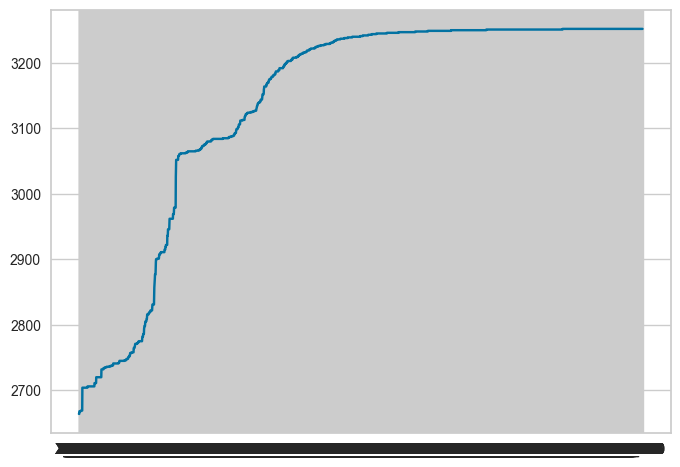

In [9]:
# 상관계수가 높은 col이 많을 수록 학습에 악영향 끼칠 것으로 판단하여 제거할 필요있음
# category feature는 제외하고 차원 축소 기법으로 새 col 만들거나 col 선택
plt.plot(re)
# plt.bar(x = re.index,height=re.values)
# plt.show()

In [10]:
re[re.index[re>2750]]

X_2525    2751
X_2829    2751
X_2524    2751
X_1915    2751
X_1917    2751
          ... 
X_2999    3252
X_2998    3252
X_617     3252
X_112     3252
X_778     3252
Length: 2967, dtype: int64

In [11]:
from sklearn.manifold import TSNE

n_components = 2

# t-sne 모델 생성
model = TSNE(n_components=n_components)

# 학습한 결과 2차원 공간 값 출력
r =model.fit_transform(re[re.index[re>2750]].to_numpy().reshape(-1,1))

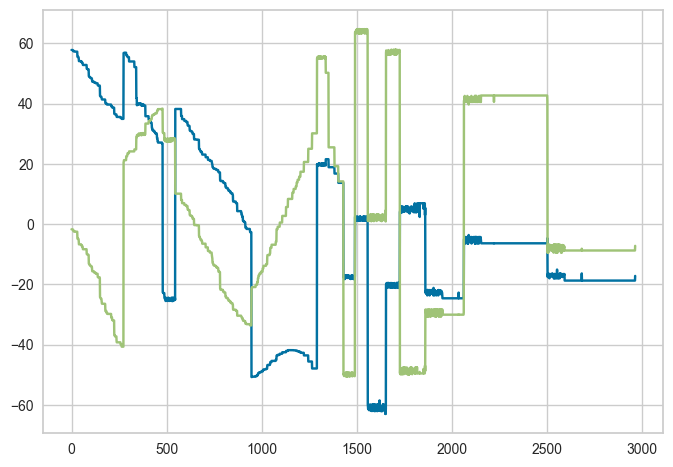

In [12]:
plt.plot(r)

In [13]:
null_counts = train_x.isna().sum(axis=0).sort_values()

# 결측치가 없는 column 추출
no_nulls = null_counts[null_counts <= 1000]

# train_x[no_nulls.index].hist()
no_nulls.index
null_counts

LINE               0
PRODUCT_CODE       0
X_84             294
X_83             294
X_82             294
                ... 
X_934           1116
X_2872          1128
X_2874          1128
X_2875          1128
X_2873          1128
Length: 3254, dtype: int64

In [14]:
train_x[['LINE', 'PRODUCT_CODE','X_762']].corr()

,X_762
X_762,1.0


In [15]:
# corr_df = train_x.corr()
# l = len(corr_df.index)

# for col in corr_df.columns:
#     for i in range(l):
        

In [16]:
train_x = train_x.fillna(0)
test_x = test_x.fillna(0)

In [17]:
# qualitative to quantitative
qual_col = ['LINE', 'PRODUCT_CODE']

for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train_x[i])
    train_x[i] = le.transform(train_x[i])
    
    for label in np.unique(test_x[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test_x[i] = le.transform(test_x[i]) 
print('Done.')

Done.


In [18]:
# # z = (x - u) / s
# scaler = StandardScaler()
# train_x = scaler.fit_transform(train_x)
# test_x = scaler.transform(test_x)

In [19]:
# category(int) / float feature
def feature_type(df,use_iloc = False):
    """
    use_iloc : 
        dataframe columns type. 
        
        ex.
            df.col or df[col] ->  False 
            df.iloc[:,col] -> True 
    """
    cate_features = []
    drop_features =[]
    float_features =[]

    for i,col in enumerate(df.columns):
        isfloat = False
        for j,v in enumerate(df[col].unique()):
            try:
                if not v.is_integer():
                    isfloat = True
                    break
            except:
                if not type(v) == np.int32:
                    isfloat = True
                    break
        if not isfloat:
            if j > 1:
                cate_features.append(i if use_iloc else col)
            else :
                if df[col].unique()[0] == -1:
                    drop_features.append(i if use_iloc else col) # not use
            # print(f"{col} unique : {df[col].unique()}")    
        # 정수를 제외한 float feature
        else:
            float_features.append(i if use_iloc else col)   
            # 전체 평균
            # df[col] = train_df[col].fillna(df[col].mean()) # nan 값 제외한 평균
            # # 클래스 별 평균
            # for k in range(3):
            #     df[col] = train_df[[col,'Y_Class']][train_df['Y_Class']==k].mean()[0]
    print(len(cate_features),len(drop_features),len(float_features))
    return cate_features,drop_features,float_features

In [20]:
a = feature_type(train_df)

0 0 3331


In [21]:
# drop nan feature 
c_features,d_features,f_features = feature_type(train_x)
train_x = train_x.drop(columns=d_features)
test_x = test_x.drop(columns=d_features)


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
scaler = StandardScaler()
# train_x[f_features] = scaler.fit_transform(train_x[f_features])
# test_x[f_features] = scaler.transform(test_x[f_features])

In [ ]:
print(train_y.unique())
train = pd.concat([train_x,train_y],axis=1)
train.head()

[1 2 0]


,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326,Y_Class
0,4,2,2.0,95.0,0.0,45.0,10.0,0.0,45.0,10.0,...,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006,1
1,5,2,2.0,96.0,0.0,45.0,10.0,0.0,53.0,10.0,...,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029,1
2,5,2,2.0,95.0,0.0,45.0,10.0,0.0,60.0,10.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,1
3,5,2,2.0,87.0,0.0,45.0,10.0,0.0,53.0,10.0,...,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031,1
4,5,2,2.0,95.0,0.0,45.0,10.0,0.0,51.0,10.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,1


In [ ]:
reg = setup(data = train, target = 'Y_Class', 
            silent=True, session_id = SEED,
            use_gpu=True,
            remove_outliers=False,
            fold=5,
            categorical_features=['LINE','PRODUCT_CODE'],
            train_size=0.8)

,Description,Value
0,session_id,37
1,Target,Y_Class
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(1132, 3255)"
5,Missing Values,False
6,Numeric Features,2968
7,Categorical Features,286
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
train.Y_Class.value_counts()


1    766
2    201
0    165
Name: Y_Class, dtype: int64

## Classification Model Fit

In [ ]:
best5_model = compare_models(fold = 5, n_select = 3)
print('Done.')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7414,0.7302,0.5399,0.7230,0.7142,0.3751,0.3969,0.7540
rf,Random Forest Classifier,0.7293,0.7442,0.4854,0.7149,0.6838,0.2924,0.3383,0.5160
catboost,CatBoost Classifier,0.7227,0.7318,0.4847,0.6995,0.6805,0.2866,0.3233,32.7720
et,Extra Trees Classifier,0.7204,0.7485,0.4762,0.6952,0.6752,0.2783,0.3169,0.5180
lightgbm,Light Gradient Boosting Machine,0.7204,0.7271,0.5007,0.6980,0.6867,0.3078,0.3330,2.6200
gbc,Gradient Boosting Classifier,0.7149,0.7241,0.4865,0.6841,0.6778,0.2863,0.3130,4.3820
xgboost,Extreme Gradient Boosting,0.7127,0.7191,0.5007,0.6866,0.6811,0.2989,0.3190,1.7520
lr,Logistic Regression,0.7105,0.7080,0.4557,0.6730,0.6623,0.2506,0.2869,1.1580
ridge,Ridge Classifier,0.6961,0.0000,0.4276,0.6450,0.6395,0.1991,0.2317,0.2060
dummy,Dummy Classifier,0.6829,0.5000,0.3333,0.4663,0.5542,0.0000,0.0000,0.0080


Done.


In [ ]:
tune_models = []
for model in best5_model:
    tune_models.append(tune_model(model,fold=5,n_iter=15))

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7188,0.6952,0.4857,0.7210,0.6660,0.2953,0.3607
1,0.7708,0.8344,0.5451,0.7651,0.7304,0.4356,0.4911
2,0.7188,0.7995,0.5112,0.6884,0.6912,0.3571,0.3728
3,0.7263,0.7393,0.5016,0.7069,0.6876,0.3179,0.3551
4,0.6947,0.7700,0.5562,0.6820,0.6849,0.3361,0.3395
Mean,0.7259,0.7677,0.5200,0.7127,0.6920,0.3484,0.3838
Std,0.0249,0.0480,0.0266,0.0296,0.0211,0.0481,0.0547


In [ ]:
# tune model 로 blend 아래 boosting 결과 다음 실행 예정

In [ ]:
blended = blend_models(estimator_list = best5_model,fold=5)
# ensemble = ensemble_model (blended, fold = 5, method = 'Boosting')
final_model = finalize_model(blended)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7514,0.7520,0.5097,0.7567,0.7090,0.3445,0.4011
1,0.7459,0.7914,0.4857,0.7430,0.6952,0.3127,0.3797
2,0.7514,0.7295,0.5387,0.7480,0.7189,0.3630,0.4039
3,0.7293,0.7464,0.4700,0.7274,0.6750,0.2715,0.3376
4,0.7624,0.8091,0.5306,0.7486,0.7245,0.3971,0.4443
Mean,0.7481,0.7657,0.5069,0.7447,0.7045,0.3378,0.3933
Std,0.0108,0.0297,0.0260,0.0097,0.0178,0.0430,0.0348


In [ ]:
f1 = finalize_model(model)
f2 = finalize_model(tune)

## Inference

In [ ]:
preds = predict_model(final_model, data = test_x)['Label']
print('Done.')

Done.


In [ ]:
for i in range(len(train_y.unique())):
    print(len(preds[preds ==i]))

34
418
83


## Submit

In [ ]:
current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y_%m_%d_%H_%M")
os.makedirs('./result',exist_ok=True)
submit = pd.read_csv('./sample_submission.csv')
submit['Y_Class'] = preds
submit.to_csv(f'./result/pycaret_knn_rf_cat_submission_{formatted_datetime}.csv', index=False)